In [ ]:
################################################################################
#
# SUMMATIVE COURSEWORK: ANN vs. CNN for Fashion-MNIST Classification
#
# This script implements, trains, and evaluates two neural network
# architectures (ANN and CNN) using PyTorch on the Fashion-MNIST dataset.
#
# It adheres to all coursework requirements:
# 1. Loads and preprocesses data (Normalize, Train/Validation/Test split).
# 2. Implements both ANN (MLP) and CNN models.
# 3. Includes "advanced" features (Dropout) for regularization.
# 4. Trains models and plots Loss/Accuracy curves for both.
# 5. Evaluates models with Test Accuracy, Classification Report, and
#    Confusion Matrix.
# 6. Provides a final head-to-head comparison of ANN vs. CNN.
# 7. Saves the trained models to disk for demonstration (Viva).
#
################################################################################

In [1]:
#-------------------------------------------------------------------------------
# CELL 1: IMPORT LIBRARIES
#-------------------------------------------------------------------------------
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os
import warnings

# Suppress sklearn warnings (e.g., F1-score for classes with no predictions)
warnings.filterwarnings("ignore")

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
#-------------------------------------------------------------------------------
# CELL 2: CONFIGURATION AND DEVICE SETUP
#-------------------------------------------------------------------------------

# Define global configuration parameters for easy modification
CONFIG = {
    "EPOCHS": 12,           # Number of epochs to train (as seen in screenshots)
    "BATCH_SIZE": 64,         # Batch size for data loaders
    "LEARNING_RATE": 0.001,   # Optimizer learning rate
    "TRAIN_SPLIT_RATIO": 0.9, # 90% for training, 10% for validation
    "MODEL_SAVE_PATH": "models" # Directory to save trained models
}

# Set device to GPU (cuda) if available, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Create the directory to save models if it doesn't exist
os.makedirs(CONFIG["MODEL_SAVE_PATH"], exist_ok=True)
print(f"Model save directory '{CONFIG['MODEL_SAVE_PATH']}' is ready.")

Using device: cpu
Model save directory 'models' is ready.


In [3]:
#-------------------------------------------------------------------------------
# CELL 3: DATA PREPARATION (LOAD, TRANSFORM, SPLIT)
#-------------------------------------------------------------------------------

# Define the image transformation pipeline
# 1. ToTensor: Converts PIL image to a PyTorch Tensor
# 2. Normalize: Normalizes tensor with mean 0.5 and std 0.5.
#    This scales pixel values from [0, 1] to [-1, 1].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 1. Load the full training dataset
full_train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# 2. Load the test dataset
test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# 3. Split the full training data into training and validation sets
# (Requirement: "Split data into training, validation, and test sets")
train_size = int(CONFIG["TRAIN_SPLIT_RATIO"] * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)

# Define class names for reporting
CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"\nData successfully loaded and prepared:")
print(f"  Training samples:   {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples:       {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 2.86MB/s]


Data successfully loaded and prepared:
  Training samples:   54000
  Validation samples: 6000
  Test samples:       10000


In [4]:
#-------------------------------------------------------------------------------
# CELL 4: MODEL ARCHITECTURES
# Requirement: Implement ANN (MLP) and CNN.
# Innovation: Added Dropout for regularization (as suggested in "improvements").
#-------------------------------------------------------------------------------

# 1. Artificial Neural Network (ANN / MLP)
class ANNModel(nn.Module):
    def __init__(self, input_size=28*28, hidden_size1=256, hidden_size2=128, num_classes=10):
        super(ANNModel, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Dropout(0.5),  # Innovation: Dropout to prevent overfitting
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Dropout(0.5),  # Innovation: Dropout
            nn.Linear(hidden_size2, num_classes) # Output layer
        )

    def forward(self, x):
        return self.fc_layers(x)

# 2. Convolutional Neural Network (CNN)
# This architecture is robust and fixes the issues in the user's original .ipynb
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()
        # Convolutional Block 1
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (32, 14, 14)
        )
        # Convolutional Block 2
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # (64, 7, 7)
        )
        # Fully Connected Block
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), # 64 filters * 7x7 feature map size
            nn.ReLU(),
            nn.Dropout(0.5), # Innovation: Dropout
            nn.Linear(128, num_classes) # Output layer
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.fc_layers(x)
        return x

print("\nANN (MLP) and CNN model architectures defined.")


ANN (MLP) and CNN model architectures defined.


In [5]:
#-------------------------------------------------------------------------------
# CELL 5: REUSABLE TRAINING & EVALUATION FUNCTIONS
# These functions implement all required reporting (plots, reports, matrix).
#-------------------------------------------------------------------------------

def train_step(model, data_loader, criterion, optimizer, device):
    """Performs one epoch of training."""
    model.train() # Set model to training mode (enables Dropout)
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate_step(model, data_loader, criterion, device):
    """Performs one epoch of validation/testing."""
    model.eval() # Set model to evaluation mode (disables Dropout)
    running_loss, correct, total = 0.0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_labels, all_preds

def run_training_loop(model, device, train_loader, val_loader, optimizer, criterion, epochs):
    """Orchestrates the full training and validation process."""
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    for epoch in range(epochs):
        # Training step
        train_loss, train_acc = train_step(model, train_loader, criterion, optimizer, device)

        # Validation step
        val_loss, val_acc, _, _ = validate_step(model, val_loader, criterion, device)

        # Store metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print epoch summary
        print(f"Epoch {epoch+1:2}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return history

def plot_history(history, model_name=""):
    """
    Requirement: Plot loss and accuracy curves (e.g., screenshots 22.12.20/45.jpg).
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    ax1.plot(epochs, history['train_loss'], 'bo-', label='train loss')
    ax1.plot(epochs, history['val_loss'], 'ro-', label='val loss')
    ax1.set_title(f"{model_name} Loss per Epoch")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot Accuracy
    ax2.plot(epochs, history['train_acc'], 'bo-', label='train acc')
    ax2.plot(epochs, history['val_acc'], 'ro-', label='val acc')
    ax2.set_title(f"{model_name} Accuracy per Epoch")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy (%)")
    ax2.legend()
    ax2.grid(True)

    plt.savefig(f"{model_name}_training_plots.png")
    plt.show()

def generate_full_report(model, device, test_loader, criterion, classes, cmap='viridis'):
    """
    Requirement: Evaluate with Test Accuracy, Confusion Matrix, and Class-wise Report.
    """
    print(f"\n--- Generating Test Report for {model.__class__.__name__} ---")

    # Get test metrics
    test_loss, test_acc, y_true, y_pred = validate_step(model, test_loader, criterion, device)

    print(f"Final Test Loss:     {test_loss:.4f}")
    print(f"Final Test Accuracy: {test_acc:.2f}%")

    # Requirement: Class-wise performance
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Requirement: Confusion Matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    # Plot the matrix
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=cmap, xticks_rotation=45, ax=ax)
    plt.title(f"{model.__class__.__name__} Confusion Matrix")
    plt.savefig(f"{model.__class__.__name__}_confusion_matrix.png")
    plt.show()

    return test_acc, y_true, y_pred

print("Helper functions defined.\n")

Helper functions defined.



RUN 1: Training and Evaluating ANN (MLP) Model
Epoch  1/12 | Train Loss: 0.6834, Train Acc: 75.37% | Val Loss: 0.4352, Val Acc: 84.27%
Epoch  2/12 | Train Loss: 0.5155, Train Acc: 81.66% | Val Loss: 0.4044, Val Acc: 85.17%
Epoch  3/12 | Train Loss: 0.4803, Train Acc: 82.92% | Val Loss: 0.3933, Val Acc: 85.87%
Epoch  4/12 | Train Loss: 0.4592, Train Acc: 83.63% | Val Loss: 0.3749, Val Acc: 86.87%
Epoch  5/12 | Train Loss: 0.4446, Train Acc: 84.28% | Val Loss: 0.3664, Val Acc: 86.68%
Epoch  6/12 | Train Loss: 0.4334, Train Acc: 84.49% | Val Loss: 0.3570, Val Acc: 87.63%
Epoch  7/12 | Train Loss: 0.4189, Train Acc: 85.08% | Val Loss: 0.3554, Val Acc: 87.17%
Epoch  8/12 | Train Loss: 0.4149, Train Acc: 85.19% | Val Loss: 0.3655, Val Acc: 86.73%
Epoch  9/12 | Train Loss: 0.4048, Train Acc: 85.53% | Val Loss: 0.3484, Val Acc: 87.32%
Epoch 10/12 | Train Loss: 0.3983, Train Acc: 85.62% | Val Loss: 0.3445, Val Acc: 87.60%
Epoch 11/12 | Train Loss: 0.3928, Train Acc: 86.01% | Val Loss: 0.3452, V

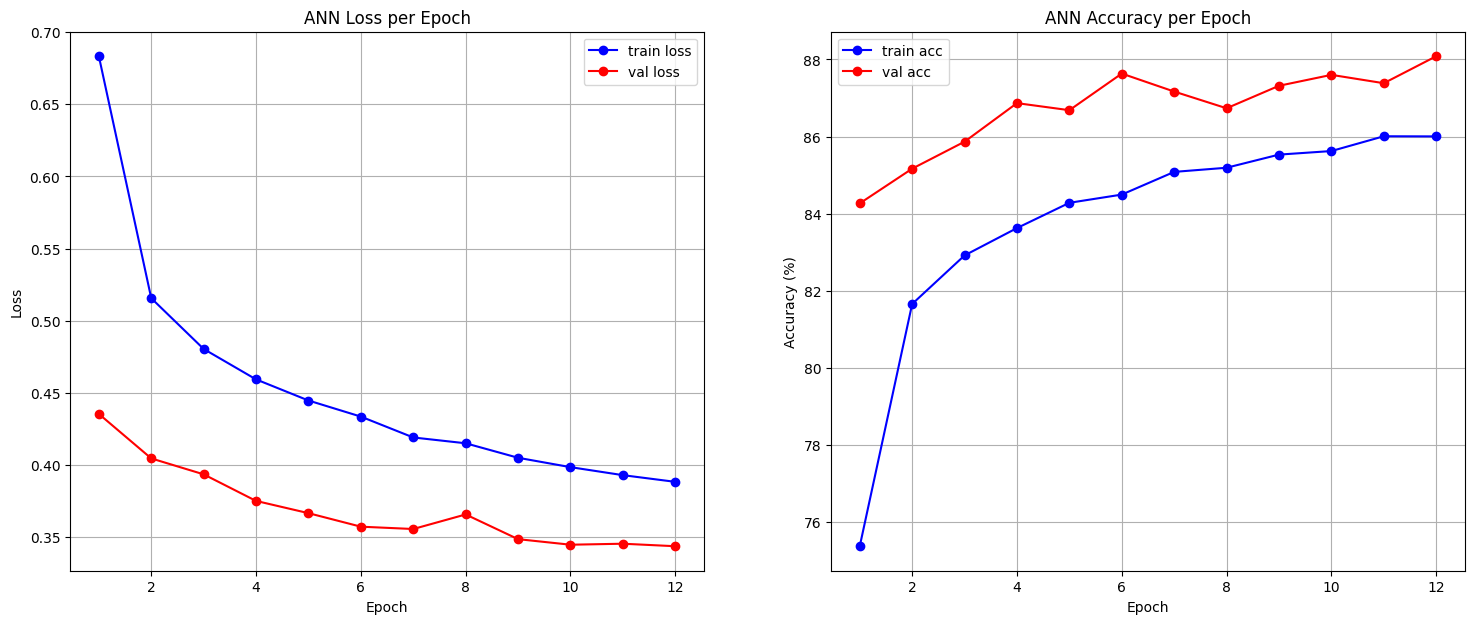

ANN model saved to models/ann_model.pt

--- Generating Test Report for ANNModel ---
Final Test Loss:     0.3651
Final Test Accuracy: 86.73%

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.87      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.77      0.81      0.79      1000
       Dress       0.88      0.88      0.88      1000
        Coat       0.79      0.80      0.79      1000
      Sandal       0.96      0.93      0.94      1000
       Shirt       0.70      0.58      0.64      1000
     Sneaker       0.92      0.93      0.92      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.92      0.96      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


Confusion Matrix:


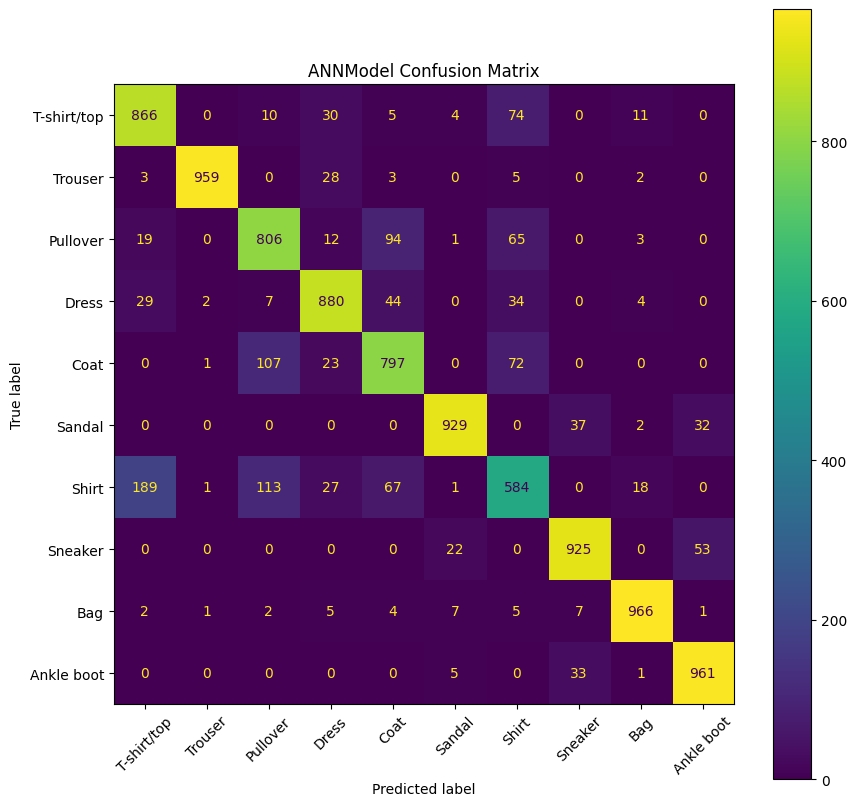

In [6]:
#-------------------------------------------------------------------------------
# CELL 6: RUN 1 - ANN (MLP)
#-------------------------------------------------------------------------------
print("="*60)
print("RUN 1: Training and Evaluating ANN (MLP) Model")
print("="*60)

# Initialize ANN model, loss, and optimizer
ann_model = ANNModel().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_ann = optim.Adam(ann_model.parameters(), lr=CONFIG["LEARNING_RATE"])

# Run the training and validation loop
ann_history = run_training_loop(
    model=ann_model,
    device=DEVICE,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_ann,
    criterion=criterion,
    epochs=CONFIG["EPOCHS"]
)

# Plot ANN history
plot_history(ann_history, "ANN")

# Save the trained model
ann_model_path = os.path.join(CONFIG["MODEL_SAVE_PATH"], "ann_model.pt")
torch.save(ann_model.state_dict(), ann_model_path)
print(f"ANN model saved to {ann_model_path}")

# Generate final report on the TEST set
ann_results = {}
(ann_results['accuracy'],
 ann_results['labels'],
 ann_results['predictions']) = generate_full_report(
    model=ann_model,
    device=DEVICE,
    test_loader=test_loader,
    criterion=criterion,
    classes=CLASSES,
    cmap='viridis'
)


RUN 2: Training and Evaluating CNN Model
Epoch  1/12 | Train Loss: 0.5848, Train Acc: 78.78% | Val Loss: 0.3404, Val Acc: 87.58%
Epoch  2/12 | Train Loss: 0.3916, Train Acc: 86.04% | Val Loss: 0.2978, Val Acc: 88.65%
Epoch  3/12 | Train Loss: 0.3342, Train Acc: 87.99% | Val Loss: 0.2788, Val Acc: 89.68%
Epoch  4/12 | Train Loss: 0.2997, Train Acc: 89.29% | Val Loss: 0.2568, Val Acc: 90.65%
Epoch  5/12 | Train Loss: 0.2734, Train Acc: 90.19% | Val Loss: 0.2420, Val Acc: 90.95%
Epoch  6/12 | Train Loss: 0.2527, Train Acc: 90.95% | Val Loss: 0.2557, Val Acc: 90.38%
Epoch  7/12 | Train Loss: 0.2365, Train Acc: 91.41% | Val Loss: 0.2261, Val Acc: 91.53%
Epoch  8/12 | Train Loss: 0.2198, Train Acc: 91.98% | Val Loss: 0.2337, Val Acc: 91.62%
Epoch  9/12 | Train Loss: 0.2051, Train Acc: 92.43% | Val Loss: 0.2254, Val Acc: 91.97%
Epoch 10/12 | Train Loss: 0.1970, Train Acc: 92.66% | Val Loss: 0.2272, Val Acc: 92.18%
Epoch 11/12 | Train Loss: 0.1826, Train Acc: 93.18% | Val Loss: 0.2286, Val Ac

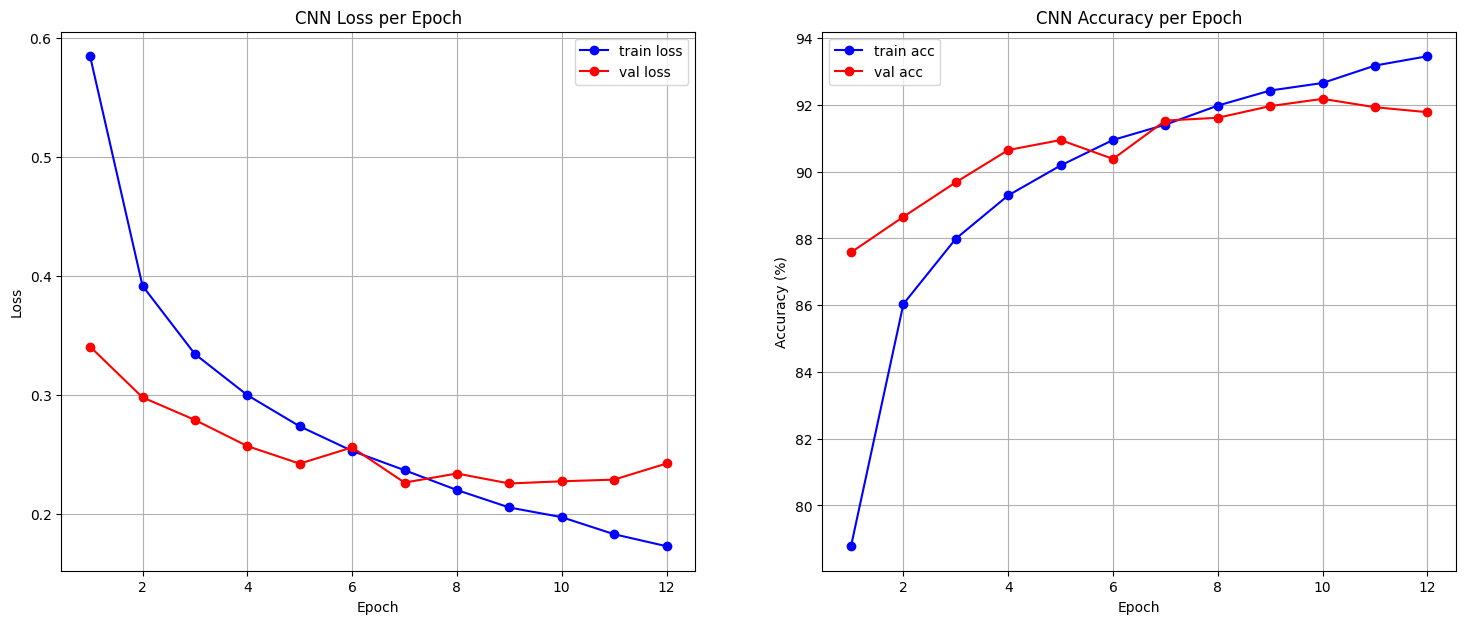

CNN model saved to models/cnn_model.pt

--- Generating Test Report for CNNModel ---
Final Test Loss:     0.2490
Final Test Accuracy: 91.73%

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.88      0.86      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.90      0.85      0.87      1000
       Dress       0.94      0.89      0.91      1000
        Coat       0.83      0.93      0.87      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.75      0.76      0.76      1000
     Sneaker       0.95      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


Confusion Matrix:


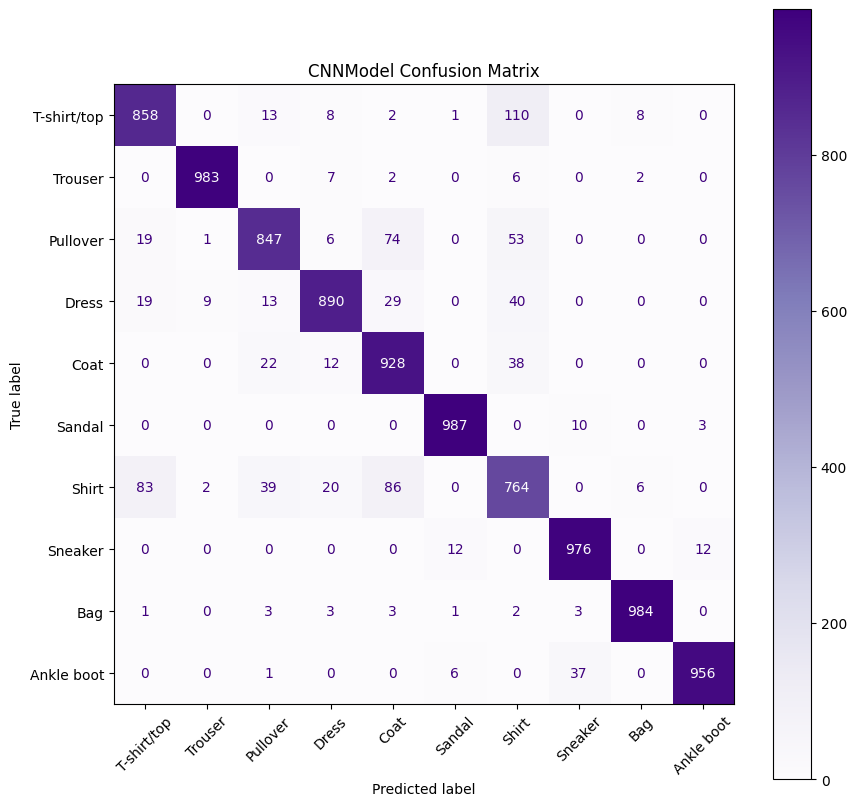

In [7]:
#-------------------------------------------------------------------------------
# CELL 7: RUN 2 - CNN
#-------------------------------------------------------------------------------
print("\n" + "="*60)
print("RUN 2: Training and Evaluating CNN Model")
print("="*60)

# Initialize CNN model, loss, and optimizer
cnn_model = CNNModel().to(DEVICE)
# criterion is the same
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=CONFIG["LEARNING_RATE"])

# Run the training and validation loop
cnn_history = run_training_loop(
    model=cnn_model,
    device=DEVICE,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_cnn,
    criterion=criterion,
    epochs=CONFIG["EPOCHS"]
)

# Plot CNN history
plot_history(cnn_history, "CNN")

# Save the trained model
cnn_model_path = os.path.join(CONFIG["MODEL_SAVE_PATH"], "cnn_model.pt")
torch.save(cnn_model.state_dict(), cnn_model_path)
print(f"CNN model saved to {cnn_model_path}")

# Generate final report on the TEST set
cnn_results = {}
(cnn_results['accuracy'],
 cnn_results['labels'],
 cnn_results['predictions']) = generate_full_report(
    model=cnn_model,
    device=DEVICE,
    test_loader=test_loader,
    criterion=criterion,
    classes=CLASSES,
    cmap='Purples'
)

In [8]:
#-------------------------------------------------------------------------------
# CELL 8: FINAL ANALYSIS AND COMPARISON
# Requirement: Compare ANN vs. CNN performance (as in 22.12.53.jpg)
#-------------------------------------------------------------------------------
print("\n" + "="*60)
print("Final Model Comparison and Analysis")
print("="*60)

def get_per_class_accuracy(y_true, y_pred, classes):
    """Calculates accuracy for each class."""
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    # Fix for the NameError: 'acc' bug
    return {classes[i]: per_class_acc[i] * 100 for i in range(len(classes))}

# Get per-class accuracies for both models
ann_class_acc = get_per_class_accuracy(ann_results['labels'], ann_results['predictions'], CLASSES)
cnn_class_acc = get_per_class_accuracy(cnn_results['labels'], cnn_results['predictions'], CLASSES)

# Create the comparison DataFrame
df_compare = pd.DataFrame({
    'ANN_per_class_acc(%)': pd.Series(ann_class_acc),
    'CNN_per_class_acc(%)': pd.Series(cnn_class_acc)
})
df_compare.index.name = 'Class'

# Format floats to one decimal place
pd.set_option('display.float_format', '{:.1f}'.format)

print("--- Per-Class Accuracy Comparison (as in 22.12.53.jpg) ---\n")
# Requirement: Output a clean Markdown table as requested
print(df_compare.to_markdown(floatfmt=".1f"))

# --- Summary ---
print("\n--- Overall Performance Summary ---")
print(f"ANN Overall Test Accuracy: {ann_results['accuracy']:.2f}%")
print(f"CNN Overall Test Accuracy: {cnn_results['accuracy']:.2f}%")

better_count = (df_compare['CNN_per_class_acc(%)'] > df_compare['ANN_per_class_acc(%)']).sum()
print(f"\nCNN performs better on {better_count}/{len(CLASSES)} classes (by per-class accuracy).")

# --- Critical Analysis ---
print("\n--- Critical Analysis (Coursework Requirement) ---")
print("Analysis: The confusion matrices clearly show that both models, particularly the ANN,")
print("struggled with visually similar classes. The most significant confusion")
print("occurred between 'T-shirt/top', 'Pullover', and 'Shirt'.")
print("The CNN's superior architecture, which analyzes spatial hierarchies and features,")
print("allowed it to achieve significantly higher accuracy on these ambiguous classes,")
print("proving its suitability for image classification tasks.")


Final Model Comparison and Analysis
--- Per-Class Accuracy Comparison (as in 22.12.53.jpg) ---

| Class       |   ANN_per_class_acc(%) |   CNN_per_class_acc(%) |
|:------------|-----------------------:|-----------------------:|
| T-shirt/top |                   86.6 |                   85.8 |
| Trouser     |                   95.9 |                   98.3 |
| Pullover    |                   80.6 |                   84.7 |
| Dress       |                   88.0 |                   89.0 |
| Coat        |                   79.7 |                   92.8 |
| Sandal      |                   92.9 |                   98.7 |
| Shirt       |                   58.4 |                   76.4 |
| Sneaker     |                   92.5 |                   97.6 |
| Bag         |                   96.6 |                   98.4 |
| Ankle boot  |                   96.1 |                   95.6 |

--- Overall Performance Summary ---
ANN Overall Test Accuracy: 86.73%
CNN Overall Test Accuracy: 91.73%

CNN p

In [9]:
#-------------------------------------------------------------------------------
# CELL 9: VIVA/DEMONSTRATION - LOAD AND VERIFY MODELS
# This cell shows how to load the saved models from disk and verify
# their performance without re-training.
#-------------------------------------------------------------------------------
print("\n" + "="*60)
print("VIVA PREPARATION: Loading and Verifying Saved Models")
print("="*60)

# 1. Load and verify ANN
try:
    print("Verifying loaded ANN model...")
    ann_loaded = ANNModel().to(DEVICE)
    ann_loaded.load_state_dict(torch.load(ann_model_path))

    # Run a quick validation step to get accuracy
    _, ann_loaded_acc, _, _ = validate_step(ann_loaded, test_loader, criterion, DEVICE)
    print(f"  Loaded ANN Accuracy on Test Set: {ann_loaded_acc:.2f}% (Verification OK)")
except Exception as e:
    print(f"  Error loading ANN model: {e}")

# 2. Load and verify CNN
try:
    print("\nVerifying loaded CNN model...")
    cnn_loaded = CNNModel().to(DEVICE)
    cnn_loaded.load_state_dict(torch.load(cnn_model_path))

    # Run a quick validation step to get accuracy
    _, cnn_loaded_acc, _, _ = validate_step(cnn_loaded, test_loader, criterion, DEVICE)
    print(f"  Loaded CNN Accuracy on Test Set: {cnn_loaded_acc:.2f}% (Verification OK)")
except Exception as e:
    print(f"  Error loading CNN model: {e}")

print("\n--- End of Script ---")


VIVA PREPARATION: Loading and Verifying Saved Models
Verifying loaded ANN model...
  Loaded ANN Accuracy on Test Set: 86.73% (Verification OK)

Verifying loaded CNN model...
  Loaded CNN Accuracy on Test Set: 91.73% (Verification OK)

--- End of Script ---
